# Installation Notes
The `prophet` package used to be called `fbprophet`, but that is now deprecated.

# Contents
This notebbook contains a rudimentary introduction to Prophet forecasting, but it does so much more!

See the [prophet documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html) for additional learning including:
* Forecasting with a carrying capacity using logistic models
* Identifying trend changepoints
* Inclusion of holidays
* Multiplicative seasonality (this notebook)
* Outlier handling (set them to NaN)
* Diagnostics & Cross validation
* Handling "shock events" like Covid19 Lockdowns

In [1]:
from prophet import Prophet
from prophet.plot import plot_plotly
import pandas as pd
import matplotlib.pyplot as plt

# Data Prep

In [2]:
df = pd.read_csv('AirPassengers.csv')
display(df.head())
df.info()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
# month column is the wrong type; let's correct that
df['Month'] = pd.DatetimeIndex(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [4]:
# Prophet also imposes the strict condition that the input columns must be named as
# `ds` (the time column) and `y` (the metric column).
df = df.rename(columns={'Month': 'ds',
                        '#Passengers': 'y'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      144 non-null    datetime64[ns]
 1   y       144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


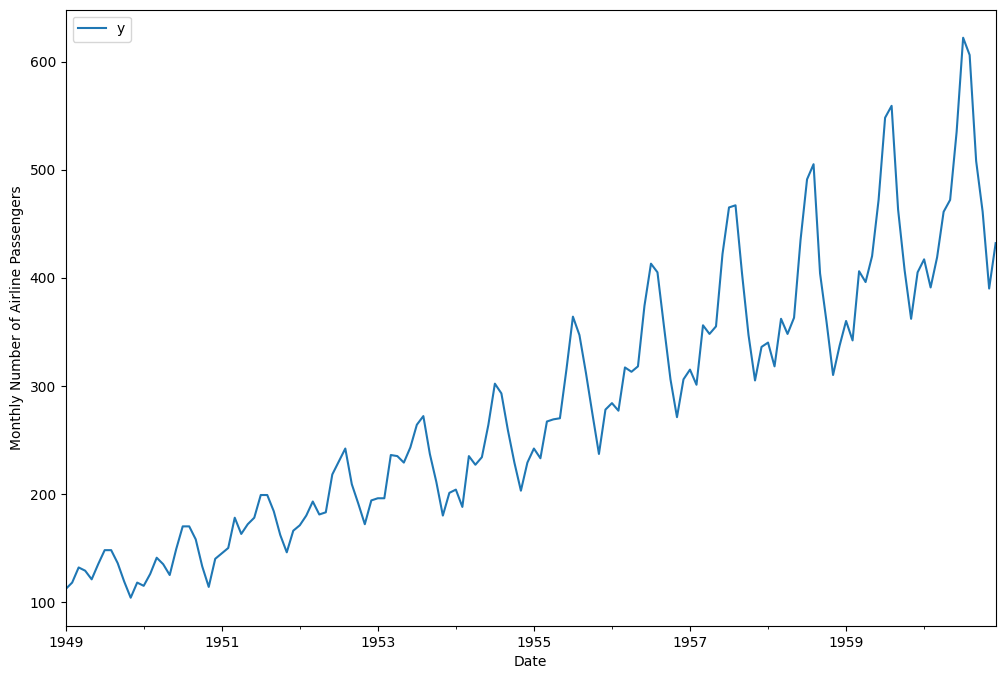

In [5]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

# Forecasting with Prophet

In [6]:
# Instantiate
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [7]:
my_model.fit(df)

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# create a dataframe of dates to predict on
future_dates = my_model.make_future_dataframe(periods=36, freq='MS') # we instructed Prophet to generate 36 months in the future
display(future_dates.tail())
print('original data size: ', df.shape)
print('prediction time series', future_dates.shape)

forecast = my_model.predict(future_dates)
display(forecast.tail())

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


original data size:  (144, 2)
prediction time series (180, 1)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
175,1963-08-01,582.644882,606.823442,691.982097,577.442274,586.997661,67.607366,67.607366,67.607366,67.607366,67.607366,67.607366,0.0,0.0,0.0,650.252248
176,1963-09-01,585.770722,559.747413,645.842846,580.400268,590.332051,17.234595,17.234595,17.234595,17.234595,17.234595,17.234595,0.0,0.0,0.0,603.005317
177,1963-10-01,588.795728,523.327481,609.357775,583.188888,593.565606,-22.023296,-22.023296,-22.023296,-22.023296,-22.023296,-22.023296,0.0,0.0,0.0,566.772432
178,1963-11-01,591.921568,489.792783,575.827413,586.021324,596.876294,-56.971509,-56.971509,-56.971509,-56.971509,-56.971509,-56.971509,0.0,0.0,0.0,534.950059
179,1963-12-01,594.946574,520.571272,605.398694,588.667779,600.072359,-30.379002,-30.379002,-30.379002,-30.379002,-30.379002,-30.379002,0.0,0.0,0.0,564.567572


The columns relevant to forecasting are:
* ds: the datestamp of the forecasted value
* yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
* yhat_lower: the lower bound of our forecasts
* yhat_upper: the upper bound of our forecasts

A variation in values from the output presented is to be expected as Prophet relies on **Markov chain Monte Carlo (MCMC)** methods to generate its forecasts.

MCMC is a stochastic process, so values will be slightly different each time.

# Visualizations

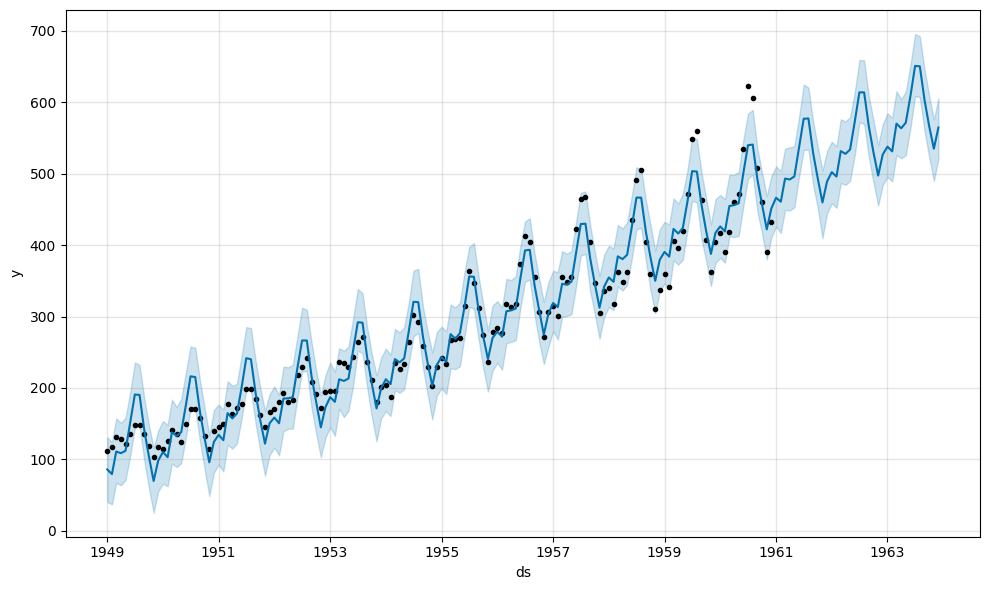

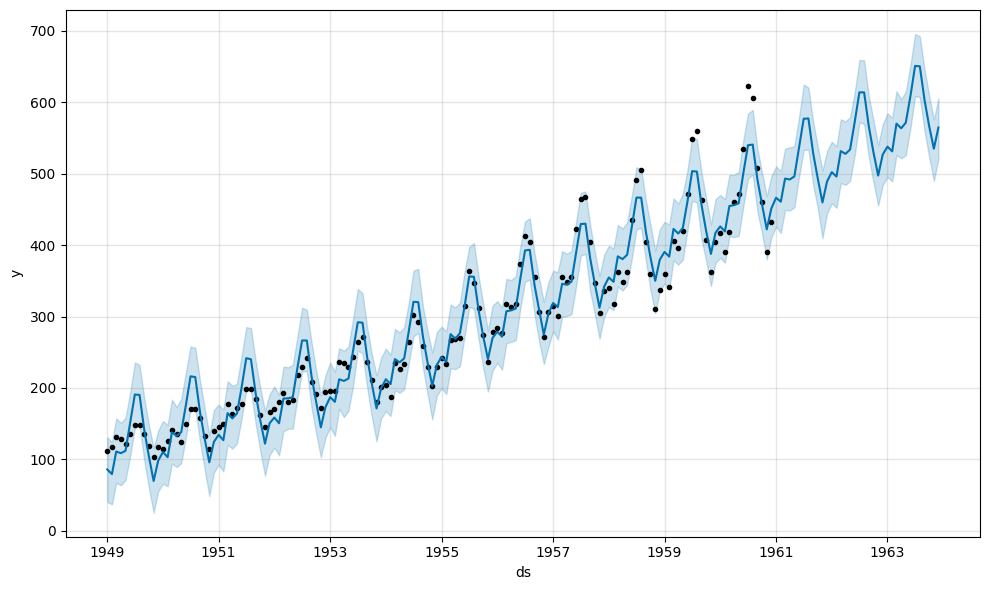

In [9]:
# visualize the predictions
my_model.plot(forecast, uncertainty=True)

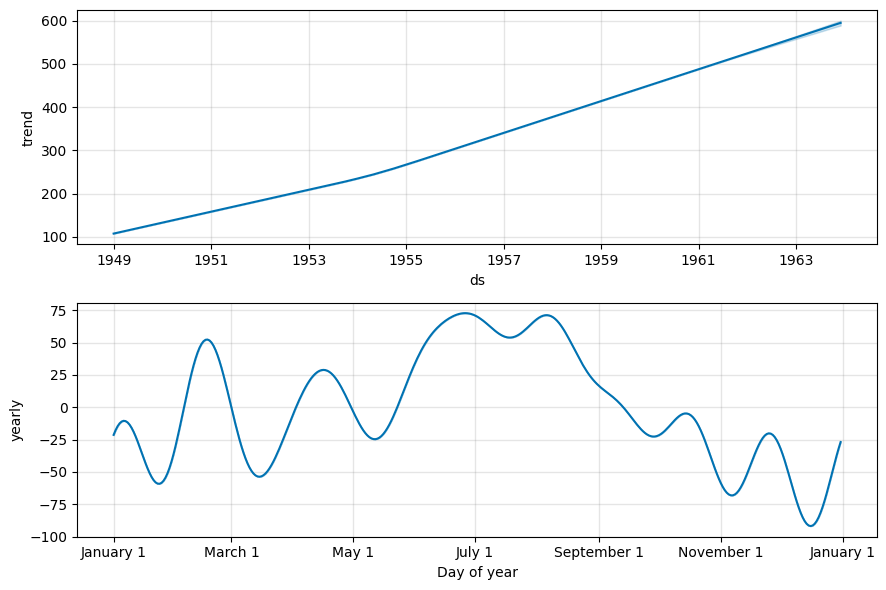

In [10]:
# now let's look at components
components = my_model.plot_components(forecast)

In the yearly view, we can see seasonality of air travel popularity. Travel seems to be
slowest right before Christmas holiday season. But something looks off. Is the travel
season busy in early March and April? Is this correct? Does this jive with your intuitive 
understanding of the world?

# Multiplicative  Seasonality
This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality.

Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the input arguments:

18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing


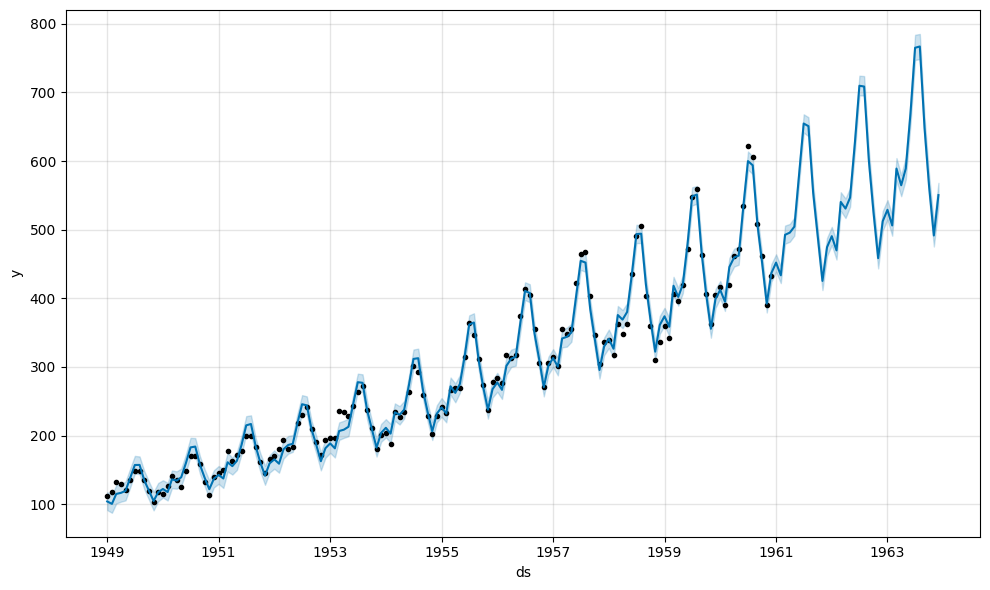

In [11]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future_dates)
fig = m.plot(forecast)

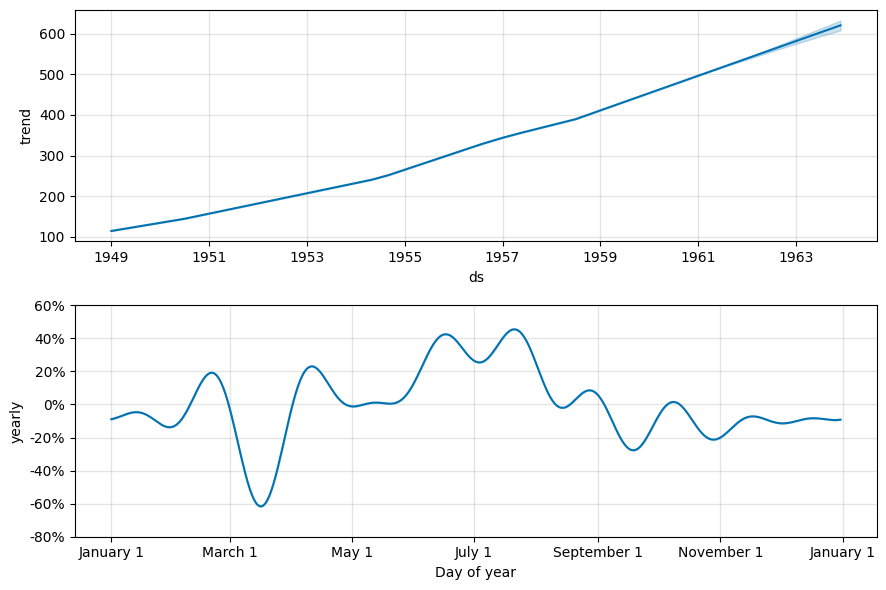

In [12]:
# The components figure will now show the seasonality as a percent of the trend:
fig = m.plot_components(forecast)


With seasonality_mode='multiplicative', holiday effects will also be modeled as multiplicative. Any added seasonalities or extra regressors will by default use whatever seasonality_mode is set to, but can be overridden by specifying mode='additive' or mode='multiplicative' as an argument when adding the seasonality or regressor.

For example, this block sets the built-in seasonalities to multiplicative, but includes an additive quarterly seasonality and an additive regressor:

```
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')
```

Additive and multiplicative extra regressors will show up in separate panels on the components plot. Note, however, that it is pretty unlikely to have a mix of additive and multiplicative seasonalities, so this will generally only be used if there is a reason to expect that to be the case.